<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/principal_component_analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis in 3 Simple Steps

Principal Component Analysis (PCA) is a simple yet popular and useful linear transformation technique that is used in numerous applications, such as stock market predictions, the  analysis of gene expression data, and many more. In this tutorial, we will see that PCA is not just a "black box", and we are going to unravel its internals in 3 basic steps.

## Sections

- [Introduction](#Introduction)
    - [PCA Vs. LDA](#PCA-Vs.-LDA)
    - [PCA and Dimensionality Reduction](#PCA-and-Dimensionality-Reduction)
    - [A Summary of the PCA Approach](#A-Summary-of-the-PCA-Approach)
- [Preparing the Iris Dataset](#Preparing-the-Iris-Dataset)
    - [About Iris](#About-Iris)
    - [Loading the Dataset](#Loading-the-Dataset)
    - [Exploratory Visualization](#Exploratory-Visualization)
    - [Standardizing](#Standardizing)
- [1 - Eigendecomposition - Computing Eigenvectors and Eigenvalues](#1---Eigendecomposition---Computing-Eigenvectors-and-Eigenvalues)
    - [Covariance Matrix](#Covariance-Matrix)
    - [Correlation Matrix](#Correlation-Matrix)
    - [Singular Vector Decomposition](#Singular-Vector-Decomposition)
- [2 - Selecting Principal Components](#2---Selecting-Principal-Components)
    - [Sorting Eigenpairs](#Sorting-Eigenpairs)
    - [Explained Variance](#Explained-Variance)
    - [Projection Matrix](#Projection-Matrix)
- [3 - Projection Onto the New Feature Space](#3---Selecting-Principal-Components)
- [Shortcut - PCA in scikit-learn](#Shortcut---PCA-in-scikit-learn)

## Introduction

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

### PCA Vs. LDA

Both Linear Discriminant Analysis (LDA) and PCA are linear transformation methods. PCA yields the directions (principal components) that maximize the variance of the data, whereas LDA also aims to find the directions that maximize the separation (or discrimination) between different classes, which can be useful in pattern classification problem (PCA "ignores" class labels).   
***In other words, PCA projects the entire dataset onto a different feature (sub)space, and LDA tries to determine a suitable feature (sub)space in order to distinguish between patterns that belong to different classes.***  

### PCA and Dimensionality Reduction

Often, the desired goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k\;<\;d$) in order to increase the computational efficiency while retaining most of the information. An important question is "what is the size of $k$ that represents the data 'well'?"

Later, we will compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the "length" or "magnitude" of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others that the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the "less informative" eigenpairs is reasonable.


### A Summary of the PCA Approach



-  Standardize the data.
-  Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
-  Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace ($k \le d$)/.
-  Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.
-  Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $k$-dimensional feature subspace $\mathbf{Y}$.

## Preparing the Iris Dataset

### Loading the Dataset

In [46]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
RAND=123

# import some data to play with
iris = datasets.load_iris()
X = iris.data

y = iris.target

X=np.hstack((X,10*np.random.random((y.shape[0], 3))))
X[:,1]=X[:,1]*X[:,0] +5*np.random.random((y.shape[0]))


X_std = scaler.fit_transform(X)





Our iris dataset is now stored in form of a  $150 \times 4$ matrix where the columns are the different features, and every row represents a separate flower sample.
Each sample row $\mathbf{x}$ can be pictured as a 4-dimensional vector   


$\mathbf{x^T} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix}
= \begin{pmatrix} \text{sepal length} \\ \text{sepal width} \\\text{petal length} \\ \text{petal width} \end{pmatrix}$

## 1 - Eigendecomposition - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

### Covariance Matrix

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d \times d$ matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$

We can summarize the calculation of the covariance matrix via the following matrix equation:   
$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$  
where $\mathbf{\bar{x}}$ is the mean vector
$\mathbf{\bar{x}} = \sum\limits_{i=1}^n x_{i}.$  
The mean vector is a $d$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

In [47]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %np.round(cov_mat, 2))

Covariance matrix 
[[ 1.01  0.64  0.88  0.82 -0.16  0.03 -0.07]
 [ 0.64  1.01  0.34  0.34 -0.2   0.06 -0.03]
 [ 0.88  0.34  1.01  0.97 -0.11  0.1  -0.06]
 [ 0.82  0.34  0.97  1.01 -0.13  0.1  -0.03]
 [-0.16 -0.2  -0.11 -0.13  1.01  0.07 -0.2 ]
 [ 0.03  0.06  0.1   0.1   0.07  1.01 -0.07]
 [-0.07 -0.03 -0.06 -0.03 -0.2  -0.07  1.01]]


The more verbose way above was simply used for demonstration purposes, equivalently, we could have used the numpy `cov` function:

Next, we perform an eigendecomposition on the covariance matrix:

In [48]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %np.round(eig_vecs, 2))
print('\nEigenvalues \n%s' %np.round(eig_vals, 2))

Eigenvectors 
[[-0.54 -0.34 -0.75 -0.   -0.13 -0.09 -0.04]
 [-0.35  0.14  0.32  0.13 -0.57  0.03 -0.64]
 [-0.53  0.77 -0.01 -0.09  0.16 -0.04  0.3 ]
 [-0.53 -0.52  0.58 -0.07  0.16 -0.02  0.3 ]
 [ 0.13 -0.01  0.02 -0.65 -0.63 -0.18  0.36]
 [-0.07 -0.02 -0.06 -0.39  0.06  0.91 -0.09]
 [ 0.03  0.01 -0.03  0.63 -0.45  0.36  0.52]]

Eigenvalues 
[3.12 0.02 0.11 1.25 0.71 0.96 0.88]


### Correlation Matrix

Especially, in the field of "Finance," the correlation matrix typically used instead of the covariance matrix. However, the eigendecomposition of the covariance matrix (if the input data was standardized) yields the same results as a eigendecomposition on the correlation matrix, since the correlation matrix can be understood as the normalized covariance matrix.

Eigendecomposition of the standardized data based on the correlation matrix:

In [49]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %np.round(eig_vecs, 2))
print('\nEigenvalues \n%s' %np.round(eig_vals, 2))

Eigenvectors 
[[-0.54 -0.34 -0.75 -0.   -0.13 -0.09 -0.04]
 [-0.35  0.14  0.32  0.13 -0.57  0.03 -0.64]
 [-0.53  0.77 -0.01 -0.09  0.16 -0.04  0.3 ]
 [-0.53 -0.52  0.58 -0.07  0.16 -0.02  0.3 ]
 [ 0.13 -0.01  0.02 -0.65 -0.63 -0.18  0.36]
 [-0.07 -0.02 -0.06 -0.39  0.06  0.91 -0.09]
 [ 0.03  0.01 -0.03  0.63 -0.45  0.36  0.52]]

Eigenvalues 
[3.1  0.02 0.11 1.24 0.7  0.95 0.88]


Eigendecomposition of the raw data based on the correlation matrix:

In [50]:
cor_mat2 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %np.round(eig_vecs, 2))
print('\nEigenvalues \n%s' %np.round(eig_vals, 2))

Eigenvectors 
[[-0.54 -0.34 -0.75 -0.   -0.13 -0.09 -0.04]
 [-0.35  0.14  0.32  0.13 -0.57  0.03 -0.64]
 [-0.53  0.77 -0.01 -0.09  0.16 -0.04  0.3 ]
 [-0.53 -0.52  0.58 -0.07  0.16 -0.02  0.3 ]
 [ 0.13 -0.01  0.02 -0.65 -0.63 -0.18  0.36]
 [-0.07 -0.02 -0.06 -0.39  0.06  0.91 -0.09]
 [ 0.03  0.01 -0.03  0.63 -0.45  0.36  0.52]]

Eigenvalues 
[3.1  0.02 0.11 1.24 0.7  0.95 0.88]


We can clearly see that all three approaches yield the same eigenvectors and eigenvalue pairs:
    
- Eigendecomposition of the covariance matrix after standardizing the data.
- Eigendecomposition of the correlation matrix.
- Eigendecomposition of the correlation matrix after standardizing the data.

### Singular Vector Decomposition

While the eigendecomposition of the covariance or correlation matrix may be more intuitiuve, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency. So, let us perform an SVD to  confirm that the result are indeed the same:

In [51]:
u,s,v = np.linalg.svd(X_std.T, full_matrices=True)
print('Vectors U:\n', np.round(u,2))

Vectors U:
 [[-0.54 -0.   -0.09  0.04  0.13  0.75 -0.34]
 [-0.35  0.13  0.03  0.64  0.57 -0.32  0.14]
 [-0.53 -0.09 -0.04 -0.3  -0.16  0.01  0.77]
 [-0.53 -0.07 -0.02 -0.3  -0.16 -0.58 -0.52]
 [ 0.13 -0.65 -0.18 -0.36  0.63 -0.02 -0.01]
 [-0.07 -0.39  0.91  0.09 -0.06  0.06 -0.02]
 [ 0.03  0.63  0.36 -0.52  0.45  0.03  0.01]]


## 2 - Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [52]:
np.round(eig_vecs,2)

array([[-0.54, -0.34, -0.75, -0.  , -0.13, -0.09, -0.04],
       [-0.35,  0.14,  0.32,  0.13, -0.57,  0.03, -0.64],
       [-0.53,  0.77, -0.01, -0.09,  0.16, -0.04,  0.3 ],
       [-0.53, -0.52,  0.58, -0.07,  0.16, -0.02,  0.3 ],
       [ 0.13, -0.01,  0.02, -0.65, -0.63, -0.18,  0.36],
       [-0.07, -0.02, -0.06, -0.39,  0.06,  0.91, -0.09],
       [ 0.03,  0.01, -0.03,  0.63, -0.45,  0.36,  0.52]])

In [53]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In order to decide which eigenvector(s) can dropped without losing too much information
for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.  
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

In [54]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
3.0984971221208104
1.2441714857984825
0.9517346719535057
0.8756159666080932
0.7016320540140499
0.10644431045568524
0.02190438904936955


### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [55]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

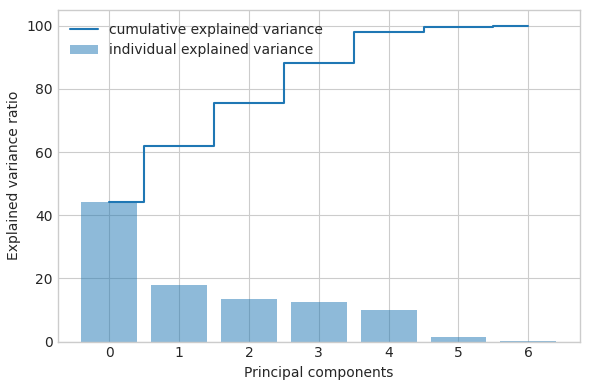

In [56]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(6, 4))
    num_of_features=len(X_std.transpose())
    plt.bar(range(num_of_features), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(num_of_features), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()


The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.

### Projection Matrix

It's about time to get to the really interesting part: The construction of the projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name "projection matrix" has a nice ring to it, it is basically just a matrix of our concatenated top *k* eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the "top 2" eigenvectors with the highest eigenvalues to construct our $d \times k$-dimensional eigenvector matrix $\mathbf{W}$.

In [57]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(num_of_features,1),
                      eig_pairs[1][1].reshape(num_of_features,1)))

print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.54370442 -0.00431915]
 [-0.34905135  0.13485592]
 [-0.53315121 -0.09062858]
 [-0.52500004 -0.06632644]
 [ 0.13145074 -0.64579275]
 [-0.06557723 -0.38957388]
 [ 0.03307167  0.63274514]]


<br>
<br>

## 3 - Projection Onto the New Feature Space

In this last step we will use the $4 \times 2$-dimensional projection matrix $\mathbf{W}$ to transform our samples onto the new subspace via the equation  
$\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$, where $\mathbf{Y}$ is a $150\times 2$ matrix of our transformed samples.

In [58]:
Y = X_std.dot(matrix_w)

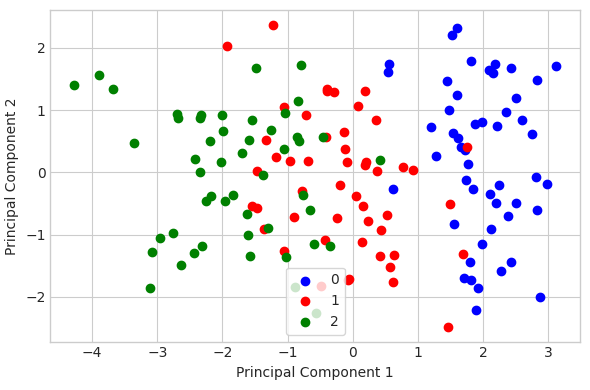

In [59]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip((0, 1, 2),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center', frameon=True)
    plt.tight_layout()



<br>
<br>
<a name="mat_pca"></a>

<br>
<br>
<a name="sklearn_pca"> </a>

## Shortcut - PCA in scikit-learn

For educational purposes, we went a long way to apply the PCA to the Iris dataset. But luckily, there is already implementation in scikit-learn.

In [60]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

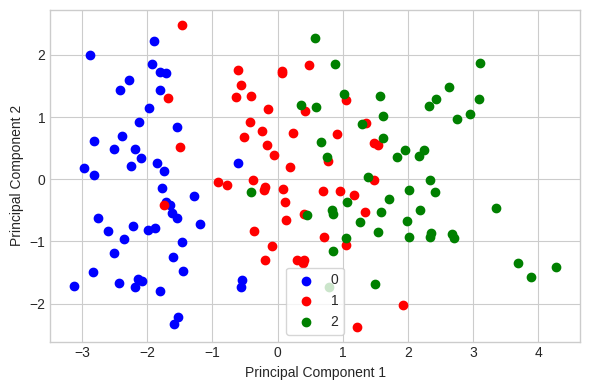

In [61]:
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip((0, 1, 2),
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center', frameon=True)
    plt.tight_layout()
    plt.show()